In [2]:
using EzXML
using Plots
using NPZ

# Relating Time

The goal of this notebook is to use the 10s synchronisation flags to temporally relate the O2 and LFP data. 

In [3]:
# Get the XML metadata file

lfp_path = "Exp 2/R7/2022-05-11_17-39-17/Record Node 101/"
files_xml = root(readxml("../../data/$(lfp_path)Continuous_Data.openephys"))
sample_rate = parse(Int, firstelement(files_xml)["samplerate"])

recording = firstelement(firstelement(files_xml))

# Format XML data into Dict
files = Dict("processor" => recording["id"], "name" => [], "filename" => [], "position" => [], "bitVolts" => [])
for elem in eachelement(recording)
    push!(files["name"], elem["name"])
    filename = replace(elem["filename"], r"continuous$"=>"")
    push!(files["filename"], "$(filename)npz")
    push!(files["position"], elem["position"])
    push!(files["bitVolts"], elem["bitVolts"])
end

In [4]:
# Indexing lfp_data[channel, datapoint]

# Add data from each channel into a single matrix
n_datapoints = length(npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][1])", ["data"])["data"][1:end-1024])
n_channels = length(files["filename"])
lfp_data = Array{Float32}(undef, n_channels, n_datapoints)
for i in 1:n_channels
    data = npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][i])", ["data"])["data"][1:end-1024] .* parse(Float64, files["bitVolts"][i])
    lfp_data[i, :] = data
end

In [5]:
# Add timestamps into vector 
# Timestamps are identical for each channel so this only needs to be done once
lfp_timestamps = npzread("../../data/formatted-lfp/$(lfp_path)$(files["filename"][1])", ["timestamps"])["timestamps"]
n_timestamps = length(lfp_timestamps)

lfp_timestamps_extended = [lfp_timestamps[i-1] + lfp_timestamps[i] * j / 1024 for i in 2:n_timestamps for j in 1:1024]
lfp_timestamps_extended ./= sample_rate

@assert length(lfp_timestamps_extended) == n_datapoints

In [6]:
events_data = npzread("../../data/formatted-lfp/$(lfp_path)all_channels.npz")

Dict{String, Vector{Float64}} with 7 entries:
  "eventId"         => [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0  …  0.…
  "channel"         => [7.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0  …  4.…
  "nodeId"          => [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0,…
  "eventType"       => [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0  …  3.…
  "timestamps"      => [25998.0, 27999.0, 28499.0, 38504.0, 39004.0, 49009.0, 4…
  "sampleNumber"    => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…
  "recordingNumber" => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.…

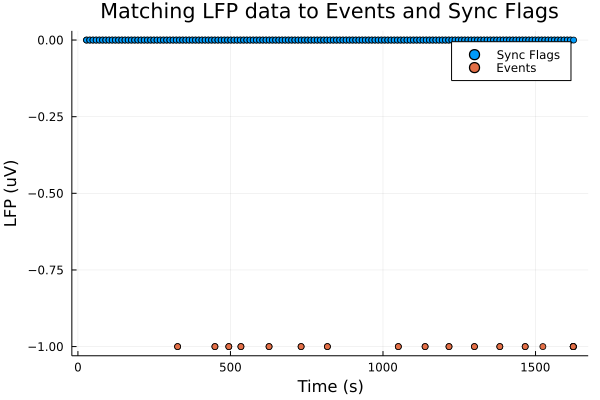

In [8]:
events_separated = []]
for event in unique(events_data["channel"])
    push!(events_separated, events_data["timestamps"][findall(x->x==event, events_data["channel"])])
end

scatter!(events_separated[2][:]./1000, zeros(100), label="Sync Flags")
scatter!(events_separated[3][:]./1000, zeros(10).-1, label="Events")

title!("Matching LFP data to Events and Sync Flags")
xlabel!("Time (s)")
ylabel!("LFP (uV)")

The next block will import the O2 data and extract the synchronisation flags.

In [11]:
# Indexing o2_data[datapoint, time/o2]

o2_path = "Exp 2/R7/"
filename = "o2 r7.txt"
o2_data = []
open("../../data/$(o2_path)$(filename)") do file
    for line in eachline(file)
        if isdigit(line[1])
            data_element = split(line, "\t")
            if length(data_element) == 2
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 0]
            else 
                data_element = [parse(Float32, data_element[1]), parse(Float32, data_element[2]), 1]
            end
            push!(o2_data, data_element)
        end
    end
end
o2_data = reduce(vcat,transpose.(o2_data))
sync_flags = o2_data[findall(x->x==1, o2_data[:,3]), 1]

164-element Vector{Float32}:
   30.452
   40.944
   51.395
   61.876
   72.372
   82.849
   93.294
  103.761
  114.266
  124.76
    ⋮
 1518.22
 1522.613
 1528.662
 1538.648
 1549.41
 1559.726
 1570.227
 1581.362
 1591.226

In [27]:
println("There are $(length(events_separated[2])/2) LFP sync flags")
println("There are $(length(sync_flags)) O2 sync flags")

There are 152.5 LFP sync flags
There are 164 O2 sync flags


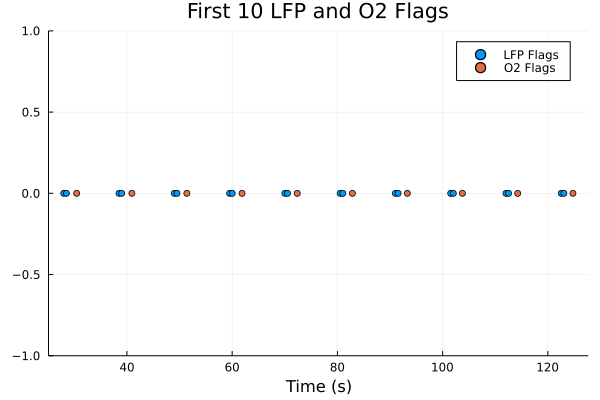

In [23]:
scatter(events_separated[2][1:20]./1000, zeros(length(events_separated[2][1:10])), label="LFP Flags")
scatter!(sync_flags[1:10], zeros(length(sync_flags[1:10])), label="O2 Flags", ylims=(-1,1))

title!("First 10 LFP and O2 Flags")
xlabel!("Time (s)")